## Summary
This notebook implements a simple [two-pass algorithm for labeling the connected components of a graph](https://en.wikipedia.org/wiki/Connected-component_labeling#Two-pass) on a 2D lattice. Specifically, a 2D matrix of floats is specified along with a threshold value. Values beneath the threshold are mapped to 0 ('background'), otherwise the values are mapped to 1 ('foreground'). Assuming 8-connectivity, adjacent foreground elements are considered to be 'connected' to one another. This is performed using a union-find data structure, which leverages [*union by rank* and *path compression*](https://en.wikipedia.org/wiki/Disjoint-set_data_structure#Disjoint-set_forests).

The 2D matrix and threshold value are passed to `first_pass`. This produces a pointer-tree: a 1D array of $N_{row} \times N_{col}$ integers. The elements of the pointer tree are sorted in conjunction with the matrix in row-major ordering. A negative value indicates the element in the matrix is a root of a connected component; the magnitude of that value indicates the total number of elements in that connected component. Otherwise a non-negative value is the flat-index that points to another element in its connected component.

For example, the pointer-tree: 
```python    
   [-3, 0, 0, -2, 3]
```
corresponds to a graph with two connected components. element-0 is the root of the component
containing `{0, 1, 2}`. element-3 is the root of the component containing `{3, 4}`.

`second_pass` then transforms the pointer tree such that all non-negative elements point directly to the root of a connected component. The 'background' elements are all grouped into a single '~~connected~~' component

## Example

```python
>>> img = np.array([ [0, 1, 1, 0],
                     [0, 0, 1, 0],
                     [1, 0, 0, 0],
                     [1, 1, 1, 1]])

# pointer tree, reshaped so that it is easy to correspond with the matrix
>>> first_pass(img, 0.99).reshape(4,4)  
array([[-8, -3,  1,  0],
       [ 0,  0,  1,  0],
       [-5,  0,  0,  0],
       [ 8,  8,  8,  8]], dtype=int64)
```

![Example Image](./ConnectComponentExample.png)

In [1]:
import numpy as np
import numba
from disjoint_forest import find_root, union

In [8]:
@numba.njit
def first_pass(img, thresh):
    """ Returns a pointer-tree indicating the connected components for `img`.
    
        Assumes 8-connectivity: foreground elements are connected if they
        are horizontally, vertically, or diagonally adjacent.
    
        Parameters
        ----------
        img : numpy.array[[float, ...], ...]
           A N by M matrix of float values.
        thresh : float
           The value below which all elements of `img` will be considered to be part
           of the 'background'.
           
        Returns
        -------
        numpy.array[int, ...]
           A NxM-length array of pointer values. """
    num_row, num_col = img.shape
    ptr = -1*np.ones(num_row*num_row, dtype=np.int64)  # initialized pointer-tree
    bkgrnd_id = -1  # initialize the root-ID of the background cluster
    n = -1  # flat-index of matrix element
    neighbor_links = [(1, (0, 1)),             # to the right
                      (num_col, (1, 0)),       # below
                      (num_col + 1, (1, 1)),   # bottom right
                      (num_col - 1, (1, -1))   # bottom left
                     ]  
    for row in range(num_row):  # ndenumerate isn't working with numba...
        for col in range(num_col):
            n += 1
            value = img[row, col]  
            if value < thresh:  # element is part of 'background'
                if bkgrnd_id == -1:
                    bkgrnd_id = n
                else:
                    union(bkgrnd_id, n, ptr)
            else:  # element is part of connected component                
                for dn, (drow, dcol) in neighbor_links:
                    n_n = n + dn
                    n_row = row + drow
                    n_col = col + dcol
                    if n_row > num_row - 1 or n_col > num_col -1:
                        continue
                    if 0 > n_row or 0 > n_col:
                        continue
                    n_value = img[n_row, n_col]
                    if n_value < thresh:
                        continue
                    union(n, n_n, ptr)
    return ptr

@numba.jit(nopython=True)
def second_pass(pntr_tree):
    """ Points all non-root elements in a pointer-tree to a root.
        
        Parameters
        ----------
        pntr_tree : numpy.array([int, ...])
        
        Returns
        -------
        numpy.array([int, ...])"""
    # TODO: add bbox memorization
    for i in range(len(pntr_tree)):
        find_root(i, pntr_tree)

In [9]:
img = np.array([ [0, 1, 1, 0],
                 [0, 0, 1, 0],
                 [1, 0, 0, 0],
                 [1, 1, 1, 1]])

In [10]:
first = first_pass(img, 0.99)

### Visualization

In [41]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
cmap = cm.Paired # colormap for matrix plot
%matplotlib notebook

@numba.njit
def imgfy_pass(pntr_tree, img):
    row, col = img.shape
    for n, i in enumerate(pntr_tree):  # 2nd pass
        find_root(n, pntr_tree)
    for n, i in enumerate(pntr_tree):
        if i < 0:
            pntr_tree[n] = n
    return pntr_tree

In [45]:
n, m = 20, 20
img = (np.random.rand(n, m) < .4).astype(np.int64)  # create a random nxm matrix
img[0, 0] = 0  # just for viz purposes

first = first_pass(img, 0.99)
scnd = imgfy_pass(first, img)

for n, val in enumerate(np.unique(scnd)):
    scnd[np.where(scnd == val)] = n

scnd = scnd.reshape(img.shape)

<IPython.core.display.Javascript object>


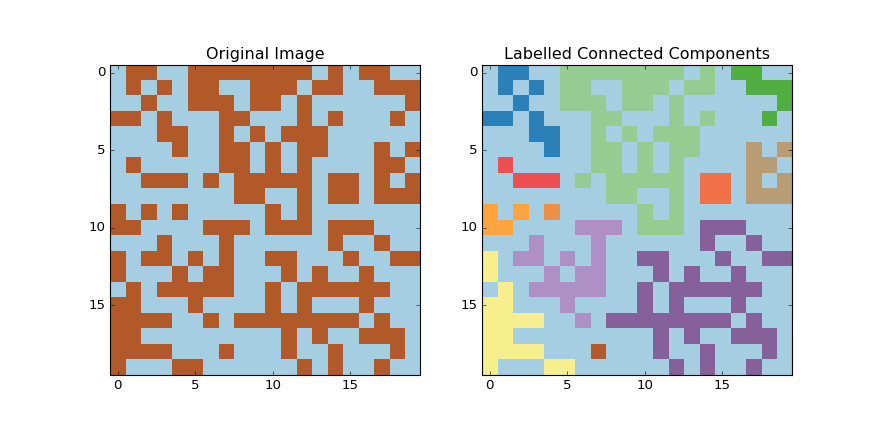

In [52]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 5.5))
ax1.imshow(img, cmap=cmap, interpolation='nearest')
ax1.set_title("Original Image")
ax2.imshow(scnd, cmap=cmap, interpolation='nearest')
ax2.set_title("Labelled Connected Components")

fig.savefig("ConnectComponentExample.png", bbox="tight")

### Benchmark

In [21]:
n, m = 200, 200
img = (np.random.rand(n, m) < .4).astype(np.int64)  # create a random nxm matrix

In [22]:
%%timeit
out = first_pass(img, .5)

100 loops, best of 3: 3.09 ms per loop


### Scratch Work

In [253]:
out = crawl_img(img, .5)

In [261]:
np.where(out < 0)

(array([  0,   6,  10,  22,  37,  53,  62,  65,  89, 102, 125, 131, 142,
        158, 170, 172, 174, 180, 198, 202, 211, 213, 215, 226, 240, 243,
        245, 251, 270, 275, 299, 314, 316, 320, 323, 332, 347, 354, 360,
        377, 394], dtype=int64),)

In [259]:
len(np.unique(out[np.where(out < 0)]))

6

In [258]:
np.unique(out[np.where(out > -1)])

array([  0,  10,  37,  53,  65, 158, 180, 198, 215, 270, 316, 323, 347,
       354, 360, 377], dtype=int64)

In [236]:
out[72]

9

In [257]:
for i in range(len(out)):
    find_root(i, out)

In [238]:
np.sum(out[np.where(out < 0)])

-400

In [237]:
print(out.reshape(img.shape))

[[-183 -137    1    0    0    0    0   25    0  -44    9    9    9    9
     9    9    9    9    9    0]
 [   0    1    1    1    0   -7   25   25    0    9    0    0    9    9
     0    0    9    0    0    9]
 [   1    1    1    1    0    0   25   25    0    9    0    9    0    0
     9    0    9    0    9    0]
 [   0    1    0    1    1    1    0   25    0    9    0    9    9    0
     0    0    9    9    9    9]
 [   1    1    0    0    0    1    1    0    0    0    9    9    9    0
     1    1    0    0    0    0]
 [   1    0    0    1    1    0    0    1    1    1    0    0    9    0
     0    1    1    1    0    1]
 [   0    0    1    1    1    1    1    1    1    0    0    0    9    0
     0    1    1    0    0    1]
 [   0    0    0    1    1    1    1    1    1    0    0    9    9    9
     0    1    0    1    1    1]
 [   0    0    0    1    0    1    0    0    0    1    1    0    9    0
     9    0    0    1    0    0]
 [   0    0    0    1    1    0    1    0    1    1    

In [16]:
[(r,c) for r,c in np.ndindex(3, 3)]

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]